# Building a Multi-Agent System with LangGraph

Welcome to the second part of our workshop! Now that we've learned the basics of LangChain and RAG, we'll explore how to build more sophisticated AI applications using **LangGraph**. We'll create a multi-agent system where different AI agents collaborate to provide comprehensive financial analysis.

## Setting Up Our Environment

Just like in our previous session, we need to set up our environment with the necessary imports and configurations. We'll use the same OpenAI models and Bloomberg news database, but we'll add some new components for our multi-agent system.

#### Global configuration

In [ ]:
#%pip install langgraph --quiet

In [1]:
# import getenv
import os
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()
# Import Azure OpenAI
from langchain_openai import AzureChatOpenAI

from IPython.display import Markdown

In [2]:
EMBEDDING_MODEL = "text-embedding-3-small"
RETRIEVAL_K = 3

#### Base model

In [3]:
from langchain_openai import AzureChatOpenAI

In [4]:
# Create a ChatOpenAI instance with the LLM model and temperature
base_model = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
)

#### Vector Store and Retriever

In [5]:
import pickle

from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import AzureOpenAIEmbeddings

In [6]:
def load_documents(pickle_filepath: str) -> list[Document]:
    """Load documents from a pickle file."""
    with open(pickle_filepath, "rb") as file:
        return pickle.load(file)


def initialize_vector_store(document_chunks: list[Document]) -> Chroma:
    """Reset the Chroma collection and initialize a vector store using document chunks."""
    Chroma().reset_collection()
    embedding_model = AzureOpenAIEmbeddings(model=EMBEDDING_MODEL)
    return Chroma.from_documents(documents=document_chunks, embedding=embedding_model)


data_dir = "./data"
data_file = "bloomberg_financial_news_1k.pkl"

# Load the Bloomberg documents from the pickle file
documents = load_documents(os.path.join(data_dir, data_file))

# Initialize the vector store with the documents
vector_store = initialize_vector_store(documents)

# Create a retriever instance from the vector store
retriever = vector_store.as_retriever(search_kwargs={"k": RETRIEVAL_K})

#### Tools

In [7]:
from langchain_core.tools import tool

In [9]:
@tool
def retrieval(retrieval_query: str) -> list[Document]:
    """Retrieve documents based on a query."""
    return retriever.invoke(retrieval_query)


# Create a list of tools and a dictionnary of tool functions by name
tools = [retrieval]
tools_by_name = {tool.name: tool for tool in tools}

print(f"Tools: {tools}")

Tools: [StructuredTool(name='retrieval', description='Retrieve documents based on a query.', args_schema=<class 'langchain_core.utils.pydantic.retrieval'>, func=<function retrieval at 0x11fe2ad40>)]


## Understanding the Multi-Agent Workflow

Our system consists of three specialized agents working together:
1. **Client Interface Agent (CIA)**: Analyzes client requests and plans research tasks
2. **Bloomberg Research Agent (BRA)**: Conducts specific research using the Bloomberg news database
3. **Research Synthesis Agent (RSA)**: Synthesizes research into final recommendations

To build our workflow with **LangGraph**, we need to implements functions that receive the current state and return state updates. These functions represent the nodes of the graph. Each node is assigned a label.

We'll use the following names for our nodes:
- Node with **CIA**: `"orchestrator"`
- Node with **BRA**: `"worker"`
- Node with **RSA**: `"synthesizer"`

![Financial Assistant Workflow](../imgs/financial-assistant-workflow.png)

## LangGraph Workflow and State

**LangGraph** helps us manage communication between our agents efficiently by defining a `State` class that will convey information from a node to the next during execution.

We keep our state simple by including only two attributes, but it's possible to include more:
- Messages: The ongoing conversation chain
- Analyses: Research findings from our agents

We use Python's dataclasses with special annotations (`Annotated`) to define how the state attributes should be updated throughout the workflow.

In [10]:
import operator
from dataclasses import dataclass, field
from typing import Annotated

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [11]:
@dataclass(kw_only=True)
class State:
    """Graph state for the financial analysis workflow."""

    messages: Annotated[list[BaseMessage], add_messages] = field(default_factory=list)
    analyses: Annotated[list[str], operator.add] = field(default_factory=list)

## The Agents in Detail

### Client Interface Agent (CIA)

The CIA serves as our system's orchestrator. It:
- Evaluates client requests
- Determines if requests are within scope
- Breaks down the request into specific tasks to be conducted by the Bloomberg Research Agents

#### Structured Outputs with Pydantic

Leveraging **Pydantic**, **LangChain** allows to constrain the output of a model using `.with_structured_output()`. Similarly to `.bind_tools()`, this provides the model with all the relevant information to structure its output in the desired way.

We define two structured outputs:
- ResearchTask: Defines specific research objectives
- OrchestratorDecision: Helps the CIA answer the client's request and plan the research tasks

This approach helps maintain consistency and reliability during our workflow execution.

In [12]:
from pydantic import BaseModel, Field

In [13]:
class ResearchTask(BaseModel):
    """Task for the financial analysis workflow."""

    topic: str = Field(description="Topic of the research task.")
    description: str = Field(
        description="Brief description of the task and its objectives."
    )


class OrchestratorDecision(BaseModel):
    """List of research tasks for the financial analysis workflow."""

    response: str = Field(description="Rationale for the decision and research tasks.")
    in_scope: bool = Field(
        description="Wether the client request is in scope for the financial analysis."
    )
    research_tasks: list[ResearchTask] | None = Field(
        description="List of research tasks to be completed."
    )

Now that the we defined our structured output, we can instanciate our CIA model using `.with_structured_output()`.

In [14]:
CIA_PROMPT = """
You are a Client Interface Agent (CIA) in a financial analysis system. You have multiple Research Agents with access to Bloomberg Financial News under your supervision.

Given a client request, provide a concise, polite and professional response regarding the feasibility of the request and the approach that will be taken to address it.

If the user's request is addressable, create a short list of highly specific research topics that the Research Agents will investigate to fulfill the client's request.
"""

# Create the CIA model from the base model with structured output
cia_model = base_model.with_structured_output(OrchestratorDecision)

#### Defining the Nodes and Flow

Let's now define our first graph Node. This section encompasses multiple **LangGraph** concepts at once and is worth spending some time on.

1. Defining the node:
    - To define our orchestrator node, we implement a function that receives the graph state and apply operations on it
    - In this case, the `"orchestrator"` calls the CIA model with structured output on the user request.

2. Defining the flow:
    - In December, **LangGraph** released [`Command`](https://blog.langchain.dev/command-a-new-tool-for-multi-agent-architectures-in-langgraph/), a novel way of defining the graph edges  directly within the nodes.
    - `Command` can return both state updates (`update`) and the next node (`goto`).
    - In the following example, the `"orchestrator"` node updates the state messages with the CIA's response.
    - If the user request is out of scope, it terminates the workflow by going to the `END` node.
    - Otherwise, it goes to a dynamically generated number of `"worker"` nodes and provide them each with a `ResearchTask`.

3. Dynamic number of nodes:
    - Instead of returning a single string in `Command` we return a list.
    - One worker is created for each research task defined by the CIA.
    - Each worker will receive a different `ResearchTask` input using [`Send`](https://langchain-ai.github.io/langgraph/concepts/low_level/#send)

In [15]:
from typing import Literal

from langchain_core.messages import SystemMessage
from langgraph.constants import Send
from langgraph.graph import END
from langgraph.types import Command

In [16]:
# Define the CIA orchestrator with the next node options
def orchestrator_node(state: State) -> Command[Literal["worker", END]]:
    """Orchestrator that generates a plan for the report."""
    display(Markdown(f"**Client request received**: {state.messages[-1].content}"))

    # Message list for the CIA model
    messages = [
        SystemMessage(CIA_PROMPT),
        *state.messages,
    ]

    # Invoke the CIA model
    cia_output = cia_model.invoke(messages)

    display(Markdown(f"**CIA Response:** {cia_output.response}"))

    return Command(
        # Update the state messages with the CIA response
        update={"messages": cia_output.response},
        # Go to worker nodes if the request is in scope, otherwise end the workflow
        goto=[Send("worker", task) for task in cia_output.research_tasks]
        if cia_output.in_scope
        else END,
    )

### Bloomberg Research Agent (BRA)

The BRA is our research specialist that:
- Receives specific research tasks from the CIA
- Queries the Bloomberg news database
- Synthesizes findings into concise research reports

This node works identically to the RAG from the first notebook.

In [17]:
from langchain_core.messages import HumanMessage, ToolMessage

In [18]:
BRA_PROMPT = """
You are a Research Agent in a financial analysis system. You are tasked with writing a concise research report on a specific topic provided by the Client Interface Agent (CIA) based on available documents.

To do so, you have access to a Bloomberg Financial News database that you can query. You should query the vector store for documents relevant to your task and write a concise summary of the information you find.

Your report should be short and informative, conveying only the most important information from the documents, to allow a Synthesis Agent to quickly generate a report for the client based on the findings of all Research Agents.
"""

# Create the BRA model from the base model with tool binding
bra_model = base_model.bind_tools(tools)

In [19]:
# Define the worker node and the next node options
def worker_node(task: ResearchTask) -> Command[Literal["synthesizer"]]:
    """Research agent that can query the vector store for relevant documents."""
    display(Markdown(f"**Researching task**: {task.topic}"))

    # Access the task topic and description from the research task
    topic = task.topic
    description = task.description

    # Create a string with the research task topic and description
    task_str = f"Research Task: {topic}\n\n Description: {description}"

    # Message list for the BRA model
    messages = [
        SystemMessage(BRA_PROMPT),
        HumanMessage(task_str),
    ]

    # Invoke the BRA model with the messages
    bra_output = bra_model.invoke(messages)

    # If the BRA model made tool calls, invoke the tool
    if bra_output.tool_calls:
        tool_call = bra_output.tool_calls[0]
        tool = tools_by_name[tool_call["name"]]
        documents = tool.invoke(tool_call["args"])

        display(
            Markdown(
                f"**Retrieved documents**: {[doc.metadata['Headline'] for doc in documents]}"
            )
        )

        # Combine the retrieved documents into a single string
        documents_str = "\n\n".join(
            [f"{doc.metadata['Headline']}\n\n{doc.page_content}\n" for doc in documents]
        )

        # Message list with the retrieved documents for the base model
        messages = [
            SystemMessage(BRA_PROMPT),
            HumanMessage(task_str),
            bra_output,
            ToolMessage(documents_str, tool_call_id=tool_call["id"]),
        ]

        # Invoke the base model with the messages
        bra_output = base_model.invoke(messages)

    # Update the state analyses with the BRA output content and go to the synthesizer node
    # NOTE: To update `analyses` you should return a list
    return Command(
        update={"analyses": [bra_output.content]},
        goto="synthesizer",
    )

### Research Synthesis Agent (RSA)
The RSA is our final processing layer that:
- Collects all research findings
- Cross-references different analyses
- Creates a cohesive final report for the client

It does not make use of tools nor structured outputs and should return an answer to the client based on the analyses in the state.

In [20]:
from langchain_core.messages import AIMessage

In [21]:
RSA_PROMPT = """
You are a Research Synthesis Agent (RSA) in a financial analysis system. You receive the reports from multiple Bloomberg Research Agents, and are tasked with synthesizing the information these reports contain into a final report for the client.

The final report should be based on the information provided by the Research Agents, covering their findings in a clear and concise manner to address the client's request.
"""

In [22]:
# Define the synthesizer node and the next node options
def synthesizer_node(state: State) -> Command[Literal[END]]:
    """Synthesize full report from research analyses."""
    display(Markdown(f"**Synthesizing research from {len(state.analyses)} BRAs.**"))

    # Access the research analyses from the state
    analyses = state.analyses

    # Combine the research analyses into a single string
    complete_analyses = "\n\n---\n\n".join(analyses)

    # Message list for the RSA model
    messages = [
        SystemMessage(RSA_PROMPT),
        *state.messages,
        AIMessage(complete_analyses),
    ]

    # Invoke the base model with the messages
    rsa_output = base_model.invoke(messages)

    # Update the state messages with the RSA output content and end the workflow
    return Command(
        update={"messages": rsa_output},
        goto=END,
    )

## Building the Workflow Graph

Now that our nodes and communication flow are defined, we can build the graph!

In [23]:
from IPython.display import Image
from langgraph.graph import StateGraph

In [24]:
# Create a state graph builder
graph_builder = StateGraph(State)

# Define the entry point
graph_builder.set_entry_point("orchestrator")

# Add the nodes
graph_builder.add_node("orchestrator", orchestrator_node)
graph_builder.add_node("worker", worker_node)
graph_builder.add_node("synthesizer", synthesizer_node)

# The edges are defined by the commands !

# Compile the workflow
app = graph_builder.compile()

Let's visualize our Financial Analyst graph. Note that because the number of `"worker"` nodes is generated dynamically, it shows up as a single node in the image.

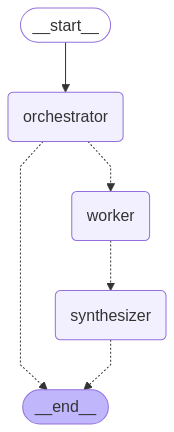

In [25]:
display(Image(app.get_graph().draw_mermaid_png()))

## Running the Workflow

Now that our workflow is built, let's test it! Once again, we can run it with `.invoke()`.

In [28]:
request = "I want to invest in the technology sector. Can you please define an investment strategy?"

# Invoke the workflow with the client request
final_state = app.invoke({"messages": request})

**Client request received**: I want to invest in the technology sector. Can you please define an investment strategy?

**CIA Response:** Investing in the technology sector is within the scope of our analysis capabilities. We will proceed by gathering insights about the sector's performance, trends, and opportunities.

**Researching task**: Technology Sector Market Trends

**Researching task**: Risks in Technology Sector Investments

**Researching task**: Top Companies in Technology Sector

**Researching task**: Historical Performance of Technology Sector

**Retrieved documents**: ['ARM Sees Shift to Cheaper Smartphones Boosting Chip Royalty', 'Ceragon Jumps Most in 1 Month on Order: Israel Overnight', 'Fewer U.S. Shares Available Fuels Bull Market: Chart of the Day']

**Retrieved documents**: ['Mairs & Power’s Frels, Henneman Named Manager of the Year', 'Fewer U.S. Shares Available Fuels Bull Market: Chart of the Day', 'Northern Trust Profit Rises 1.7% as Market Boosts Assets']

**Retrieved documents**: ['UBS’s Weber Sees Volatile Markets in 2013 on Political Risks', 'M&A Isn’t Likely to Stage ‘Major’ Recovery Yet, Shafir Says', 'Mobius Searches for China Stocks to Buy as PBOC Spurs Confidence']

**Retrieved documents**: ['Fewer U.S. Shares Available Fuels Bull Market: Chart of the Day', 'Mairs & Power’s Frels, Henneman Named Manager of the Year', 'Northern Trust Profit Rises 1.7% as Market Boosts Assets']

**Synthesizing research from 4 BRAs.**

In [29]:
Markdown(final_state["messages"][-1].content)

### Final Report: Investment Strategy for the Technology Sector

#### Overview
The technology sector continues to be a dynamic space filled with opportunities and risks. Key drivers include the expansion of affordable consumer electronics markets, innovations in specialized applications, and strategic maneuvers by major players like Apple. However, investors must also navigate macroeconomic volatility, regulatory challenges, and sector-specific risks.

#### Key Growth Areas
1. **Affordable Consumer Electronics**:
   - Affordable smartphones, projected by ARM Holdings to see significant growth, offer strong prospects for returns. These are increasingly becoming high-volume markets with declining average selling prices but higher silicon demand.
   - Companies developing mid-range technology products are well-positioned to benefit from these trends.

2. **Enterprise and Energy-Efficient Applications**:
   - ARM's focus on tailored data-center chips and micro-controllers highlights growing demand for specialized applications and energy efficiency.
   - Firms advancing sustainable technologies or addressing unique enterprise needs could be high-upside investments.

3. **Telecom Infrastructure**:
   - Telecommunication advancements, while currently facing weak demand, could see long-term growth opportunities as global mobile networking capacity expands. Companies like Ceragon Networks remain relevant, albeit constrained by current market conditions.

#### Key Players
Companies like Apple Inc., Thermo Fisher Scientific, and others dominate the space as major fund holdings. Apple's stock-buyback strategy and consistently rising market capitalization provide clear indicators of robust financial health and ongoing leadership. Large-cap tech companies with stable earnings and market tailwinds will likely remain central to technology sector growth.

#### Broader Market Metrics
The tech-heavy S&P 500 has benefited from strategic shifts like de-equitization, contributing to healthy earnings-per-share growth. Global equity markets highlight the sector’s resilience, with developed and emerging economies showing gains tied to technology innovation.

#### Risks
1. **Market Volatility**:
   - Economic uncertainty and geopolitical instability create challenges. Investors must prepare for sentiment-driven volatility, as "risk-on, risk-off" trends could temporarily disrupt sector performance.

2. **Regulatory Issues**:
   - Policies like financial system crackdowns in China may impact liquidity and sector dynamics. Regulatory interventions aiming for structural transformation or risk mitigation should be closely monitored.

3. **M&A Risks**:
   - Rising interest rates could deter deal-making activity. Corporate wariness amid global uncertainties may limit mergers and acquisitions as growth avenues.

#### Investment Strategy Recommendations
1. **Portfolio Focus**:
   - Emphasize large-cap, innovation-driven companies that maintain strong fundamentals, e.g., Apple Inc. and Thermo Fisher Scientific.
   - Diversify holdings across both consumer-facing and enterprise technology to benefit from stable and high-growth niches.

2. **Risk Mitigation**:
   - Hedge against market volatility using index funds or ETFs tied to technology benchmarks, reducing exposure to sentiment-driven fluctuations.
   - Monitor regulatory developments, particularly from global markets like China, to reduce the impact of sudden interventions.

3. **Long-Term Approach**:
   - Given the sector’s historical resilience and outsized returns, prioritize consistent performers and hold positions in established technology leaders for 5-10 years.

#### Conclusion
The technology sector offers ample opportunities if approached methodically. Focus on segments like affordable consumer electronics and enterprise applications while keeping an eye on global risks. Combining a diversified portfolio, sound risk management, and a long-term outlook will maximize returns in this innovative and high-potential market.

## Practical Tips

- Keep agent roles clearly defined and specialized
- Use structured outputs to ensure reliable communication
- Monitor the workflow graph for potential bottlenecks

## Conclusion

You've now learned how to build a sophisticated multi-agent system using **LangGraph**! This approach allows for:
- More complex and nuanced analysis
- Better division of responsibilities
- Scalable AI applications

Feel free to experiment with different agent configurations and workflow patterns to suit your specific needs.